# INM430 Coursework Final Submission Part-2 - Analysis Files

This notebook is to support the written report pdf file. This notebook documents all the steps required for the project submission as listed in the table of contents below.

## Table of Contents
1. [Setup](#setup)
2. [Loading the Data](#loading-the-data)
3. [Data Exploration](#data-exploration)
4. [Baseline Model](#baseline-model)
5. [Analysis](#analysis)
    * 5.1. [TF-IDF Representation](#tf-idf-representation)
    * 5.2. [Doc2Vec Representation](#doc2vec-representation)
6. [Evaluation](#evaluation)

<a name="setup"></a>
## 1. Setup

Hide errors for presentation purposes

In [40]:
# import warnings
# warnings.simplefilter(action="ignore", category=FutureWarning)
# warnings.filterwarnings(action="ignore", category=DeprecationWarning)

import warnings
warnings.filterwarnings('ignore')

Import dependencies

In [2]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt
import multiprocessing
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
from pipelinehelper import PipelineHelper
import re
import seaborn as sns
from sklearn import utils
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.svm import LinearSVC

%matplotlib inline

<a name="loading-the-data"></a>
## 2. Loading the Data

The data was collected through scraping a number of different websites as discussed in the written report. The scripts written for this data collection process are found in the scripts folder. Due to some parsing errors with the web scraper, some lyrics were not returned to appear as empty strings or null values in the CSV file.

In [3]:
tracks_by_artist = pd.read_csv("./data/tracks_with_lyrics_for_top_10_artists.csv")
tracks_by_artist = tracks_by_artist[~tracks_by_artist["lyrics"].isnull()]

In [4]:
tracks_by_artist.head()

,artist,album,track,lyrics
0,T.I.,Trap Muzik,I Can't Quit,"[Intro]\nHuh, hell nah, I can't quit\nHell nah..."
1,T.I.,Trap Muzik,Be Easy,"[Intro]\nUh-uh, uh-uh, uh\nAye, where the pian..."
2,T.I.,Trap Muzik,No More Talk,[Verse 1]\nI'm either running for my life or I...
3,T.I.,Trap Muzik,Doin My Job,"[T.I. - talking]\nAy I'm working here, know wh..."
4,T.I.,Trap Muzik,24's,"[Intro]\nYeah\nFor all my real ATL niggas, tha..."


In [5]:
tracks_by_artist.shape

(679, 4)

Have a total of 679 tracks with lyrics with artist name and album title as additional metadata

<a name="data-exploration"></a>
## 3. Data Exploration

The following illustrates the break down of the number of tracks by artist considered in this project. This has implications for the evaluation metrics I will report in the investigation. The following considerations are important to decide the evaluation metrics,

* The project deals with a supervised, multiclass classification task,
* The classes in the original dataset are unbalanced.

For these reasons, I will report the precision, recall, and weighted fscore for each model. Together, these metrics do a better job of indicating the overall accuracy of a classifier, whereas with accuracy alone, there is a risk that we are not correctly identifying a good-performing classifier but rather just one that is biased towards the more populated classes. 

Text(0.5,1,'Total Number of Tracks with Lyrics by Artist')

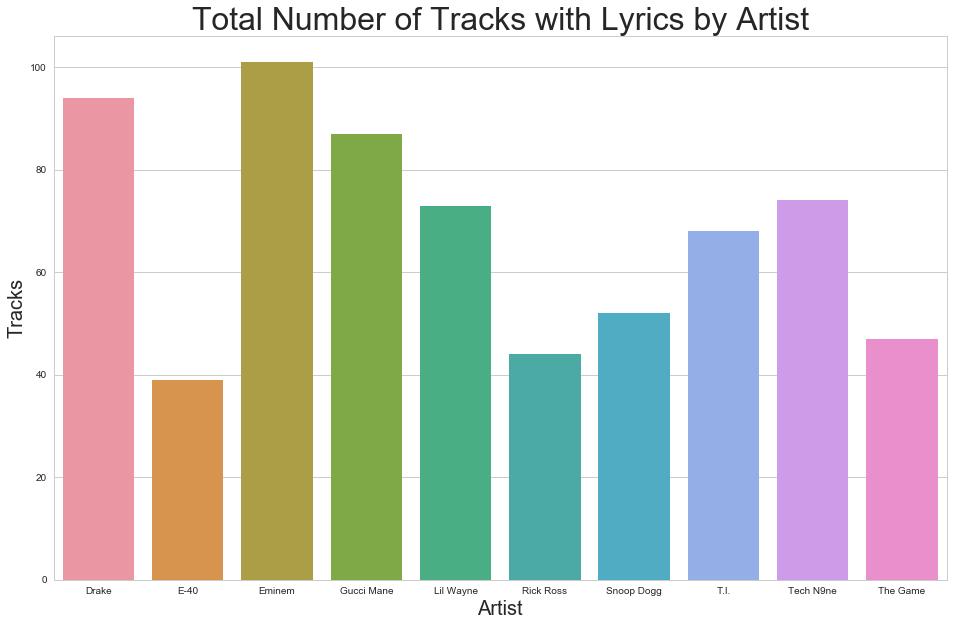

In [6]:
total_tracks_by_artist = tracks_by_artist.groupby("artist").agg("count")[["track"]]
total_tracks_by_artist = total_tracks_by_artist.reset_index()
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(16,10))
sns.barplot(ax=ax, x="artist", y="track", data=total_tracks_by_artist)
ax.set_xlabel("Artist", fontsize=20)
ax.set_ylabel("Tracks", fontsize=20)
ax.set_title("Total Number of Tracks with Lyrics by Artist", fontsize=32)

Same as above but with numbers

In [7]:
tracks_by_artist.groupby("artist")["track"].agg("count")

artist
Drake          94
E-40           39
Eminem        101
Gucci Mane     87
Lil Wayne      73
Rick Ross      44
Snoop Dogg     52
T.I.           68
Tech N9ne      74
The Game       47
Name: track, dtype: int64

<a name="baseline-model"></a>
## 4. Baseline Model

For a like to like comparison with future text representations and models, this section reports on the testing results of a logistic regression classifier using a Bag-of-Words representation. This is very basic but will help indicate whether choices for later models help to improve on the overall classification task.

In [8]:
train, test = train_test_split(tracks_by_artist, test_size=0.3, random_state=34)
y_train, X_train = train["artist"], train
y_test, X_test = test["artist"], test

In [9]:
bow = CountVectorizer()
X_train_bow = bow.fit_transform(X_train["lyrics"])
X_test_bow = bow.transform(X_test["lyrics"])

Perform grid search cross-validation to find the optimal value for the C parameter. The predictions are generated from the model with this value for C.

In [10]:
param_grid = {"C": [1e0, 1e1, 1e2, 1e3]}

logreg = GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid)
logreg.fit(X_train_bow, y_train.ravel())
y_pred = logreg.predict(X_test_bow)

prfs = precision_recall_fscore_support(y_test.ravel(), y_pred, average='weighted', labels=np.unique(y_pred))

Reported results for baseline model.

In [11]:
print('Testing Precision: {}'.format(prfs[0]))
print('Testing Recall: {}'.format(prfs[1]))
print('Testing FScore: {}'.format(prfs[2]))
print("Logistic Regression Param C: {}".format(logreg.best_params_["C"]))

Testing Precision: 0.7048856553990449
Testing Recall: 0.6862745098039216
Testing FScore: 0.686845629812127
Logistic Regression Param C: 100.0


In [15]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

    fig = plt.figure(figsize=figsize)
    
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

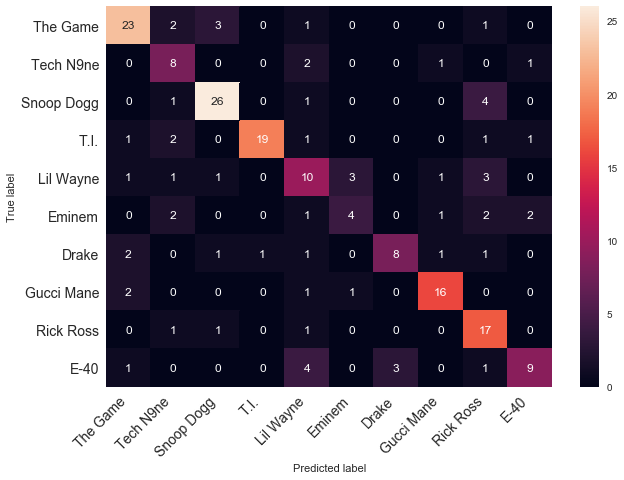

In [17]:
print_confusion_matrix(confusion_matrix(y_test, y_pred), y_test.unique().tolist())

<a name="analysis"></a>
## 5. Analysis

Models to be considered,

* Logistic Regression 
* Linear SVM
* Naive Bayes

This is because these models have generally been used by previous authors in this task and due to their effectiveness for multilcass problems in general.

The below function "best_results_by_model" is a simple way to extract the equal best performing classifier for each text representation strategy. For each classifier it finds one with the equal best mean cross-validation score against the test set considered.

In [18]:
# Helper function
def best_results_by_model(grid_scores):
    
    best_results_by_model = {}
    for score in grid_scores:
        model_name = score[0]["classifier__selected_model"][0]
        if (model_name not in best_results_by_model) or (score[1] > best_results_by_model[model_name]["mean"]):
            best_results_by_model[model_name] = {
                "params": score[0],
                "mean": score[1],
                "results": score[2],
            }
    
    return best_results_by_model   

#### Feature engineering

The features I will be considering in this project are listed below. Starting only with the raw lyrics collected by scraping an external website I had to derive all the features used in this project following a process of feature engineering.

* Vectorised track lyrics: for each text representation strategy, I will vectorise the raw lyrics according to one of two approaches: TF-IDF and Doc2Vec. This will be the main variable in the project.
* Track line count: the total number of lines in each track, breaking on newline characters "\n"
* Average line length: the number of words in each line of lyrics, averaged for each track
* Unique word proportion: the proportion of unique words out of the total number of words in a given track
* Song structure: a TF-IDF vector representation of the song structure. This follows by simply reading in the labels corresponding to different 

The features considered in this study were chosen either because something similar was used in a related paper, or because they were something I have not otherwise come across in the literature. Overall, I feel like these do a good job at characterising tracks at an artist-level, for instance in the project progress submission notebook I found that "unique word proportion" did a fairly good job at characterising artists already.

In [ ]:
Below are custom transformers used by the pipeline constructor further below. In general these perform

In [19]:
# Custom Transformers

class LyricsExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data["lyrics"].values
    
class VectorExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data["vectors"].values

class LineCountExtractor(BaseEstimator, TransformerMixin):

    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data["lyrics"].str.split("\n").apply(len)

class AverageLineLengthExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data["lyrics"].str.split("\n").apply(lambda lines: sum(map(len,lines))/len(lines))

class SongStructureExtractor(BaseEstimator, TransformerMixin):

    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data["lyrics"].apply(lambda lyrics: " ".join(re.findall(r"\[(.*)\]", lyrics)))

class UniqueWordProportionExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data["lyrics"].apply(lambda lyrics: self.__prop_unique_words(lyrics))
    
    def __prop_unique_words(self, lyrics):
        return self.__get_unique_word_count(lyrics) / self.__get_total_word_count(lyrics)
    
    def __get_total_word_count(self, lyrics):
        return len(re.split(" |\n|", lyrics))
    
    def __get_unique_word_count(self, lyrics):
        return len(set(re.split(" |\n|", lyrics)))

class ArrayCaster(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return np.transpose(np.matrix(data))
    
class ListCaster(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data.tolist()

In [20]:
# Pipelines
song_vectors = Pipeline([
                ("lyrics", LyricsExtractor()),
                ("tfidf", TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS, tokenizer=word_tokenize)),
            ])

line_count = Pipeline([
                ("get_line_count", LineCountExtractor()),
                ("caster", ArrayCaster())
            ])

average_line_length = Pipeline([
                ("get_average_line_length", AverageLineLengthExtractor()),
                ("caster", ArrayCaster())
            ])

unique_word_proportion = Pipeline([
                ("get_unique_word_proportion", UniqueWordProportionExtractor()),
                ("caster", ArrayCaster())
            ])

song_structure = Pipeline([
                ("get_song_strucutre", SongStructureExtractor()),
                ("tfidf", TfidfVectorizer(lowercase=False)),
            ])

In [21]:
featureunion = FeatureUnion([
    ("line_count", line_count),
    ("song_vectors", song_vectors),
    ("average_line_length", average_line_length),
    ("unique_word_proportion", unique_word_proportion),
    ("song_structure", song_structure)
])

In [22]:
pipeline = Pipeline([
    ("featureunion", featureunion),
    ("classifier", PipelineHelper([
        ("MultinomialNB", MultinomialNB()),
        ("LogisticRegression", LogisticRegression()),
        ("LinearSVC", LinearSVC())
    ]))
])

In [23]:
param_grid = {
    "featureunion__transformer_weights": [
        # one feature only
        {"song_vectors":1,"line_count":0, "average_line_length":0, "unique_word_proportion":0, "song_structure":0},
        # two features
        {"song_vectors":1,"line_count":0, "average_line_length":0, "unique_word_proportion":1, "song_structure":0},
        # three features
        {"song_vectors":1,"line_count":0, "average_line_length":1, "unique_word_proportion":1, "song_structure":1},
        {"song_vectors":1,"line_count":0, "average_line_length":1, "unique_word_proportion":1, "song_structure":1},
        # five features
        {"song_vectors":1,"line_count":1, "average_line_length": 1, "unique_word_proportion": 1, "song_structure": 1},
    ],
    "classifier__selected_model": pipeline.named_steps["classifier"].generate({
        "LogisticRegression__C": [1e0, 1e1, 1e2, 1e3],
        "LinearSVC__C": [1e0, 1e1, 1e2, 1e3]
    })
}

<a name="tf-idf-representation"></a>
### 5.1. TF-IDF Representation

The first text representation to be considered will be TF-IDF short for term frequency-inverse document frequent. In this representation, vectors for each song are created by weighting the number of times a given word appears in a song (term frequency). Although like BOW, this approach loses contextual information, i.e. where a given word appeared in relation to another, it does a much better job at capturing the relative importance of a given word for a given song.

Putting everything above altogether, will run through the pipeline spe

In [24]:
gs_clf = GridSearchCV(pipeline, param_grid, cv=5)

In [25]:
train, test = train_test_split(tracks_by_artist, test_size=0.3, random_state=34)
y_train, X_train = train["artist"], train
y_test, X_test = test["artist"], test

In [26]:
gs_clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('line_count', Pipeline(memory=None,
     steps=[('get_line_count', LineCountExtractor()), ('caster', ArrayCaster())])), ('song_vectors', Pipeline(memory=None,
     steps=[('lyrics', LyricsExtractor()), ('tfidf', TfidfVectorizer...andom_state=None, tol=0.0001,
     verbose=0)},
        include_bypass=False, selected_model=None))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'featureunion__transformer_weights': [{'song_vectors': 1, 'line_count': 0, 'average_line_length': 0, 'unique_word_proportion': 0, 'song_structure': 0}, {'song_vectors': 1, 'line_count': 0, 'average_line_length': 0, 'unique_word_proportion': 1, 'song_structure': 0}, {'song_vectors': 1, 'l...C', {'C': 10.0}), ('LinearSVC', {'C': 100.0}), ('LinearSVC', {'C': 1000.0}), ('MultinomialNB', {})]},
       pre_dispatch='2*n_jobs', refit=True, return_tra

In [29]:
best_results_by_model(gs_clf.grid_scores_)

{'LinearSVC': {'mean': 0.8147368421052632,
  'params': {'classifier__selected_model': ('LinearSVC', {'C': 100.0}),
   'featureunion__transformer_weights': {'average_line_length': 0,
    'line_count': 0,
    'song_structure': 0,
    'song_vectors': 1,
    'unique_word_proportion': 0}},
  'results': array([0.76767677, 0.82828283, 0.85263158, 0.86021505, 0.76404494])},
 'LogisticRegression': {'mean': 0.7957894736842105,
  'params': {'classifier__selected_model': ('LogisticRegression',
    {'C': 1000.0}),
   'featureunion__transformer_weights': {'average_line_length': 0,
    'line_count': 0,
    'song_structure': 0,
    'song_vectors': 1,
    'unique_word_proportion': 0}},
  'results': array([0.75757576, 0.7979798 , 0.85263158, 0.82795699, 0.74157303])},
 'MultinomialNB': {'mean': 0.3705263157894737,
  'params': {'classifier__selected_model': ('MultinomialNB', {}),
   'featureunion__transformer_weights': {'average_line_length': 0,
    'line_count': 0,
    'song_structure': 0,
    'song_vec

In [30]:
y_pred = gs_clf.predict(X_test)

print('Testing Precision: {}'.format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[0]))
print('Testing Recall: {}'.format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[1]))
print('Testing FScore: {}'.format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[2]))

Testing Precision: 0.8256375223072544
Testing Recall: 0.8186274509803921
Testing FScore: 0.817927798404807


In [31]:
%store gs_clf

Stored 'gs_clf' (GridSearchCV)


<a name="doc2vec-representation"></a>
### 5.2. Doc2Vec Representation

In [32]:
train, test = train_test_split(tracks_by_artist, test_size=0.3, random_state=34)
y_train, X_train = train["artist"], train
y_test, X_test = test["artist"], test

In [33]:
train_tagged = [TaggedDocument(words=word_tokenize(X_train["lyrics"].tolist()[idx]), tags=y_train.tolist()[idx]) for idx, _ in enumerate(y_train)]
test_tagged = [TaggedDocument(words=word_tokenize(X_test["lyrics"].tolist()[idx]), tags=y_test.tolist()[idx]) for idx, _ in enumerate(y_test)]

In [34]:
model_dbow = Doc2Vec(dm=0, vector_size=1000, sample=0, workers=multiprocessing.cpu_count())
model_dbow.build_vocab(train_tagged)

In [35]:
max_epochs = 30
for epoch in range(max_epochs):
    model_dbow.train(utils.shuffle(train_tagged), total_examples=model_dbow.corpus_count, epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [36]:
def vec_for_learning(model, tagged_docs):
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in tagged_docs])
    return targets, regressors

In [41]:
y_train, X_train["vectors"] = vec_for_learning(model_dbow, train_tagged)
y_test, X_test["vectors"] = vec_for_learning(model_dbow, test_tagged)

In [42]:
class ListCaster(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data.tolist()

song_vectors = Pipeline([
                ("vector", VectorExtractor()),
                ("tolist", ListCaster()),
            ])

In [43]:
doc2vec_gs_clf = GridSearchCV(pipeline, param_grid, cv=5)

In [44]:
doc2vec_gs_clf.fit(X_train, list(y_train))

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('line_count', Pipeline(memory=None,
     steps=[('get_line_count', LineCountExtractor()), ('caster', ArrayCaster())])), ('song_vectors', Pipeline(memory=None,
     steps=[('lyrics', LyricsExtractor()), ('tfidf', TfidfVectorizer...andom_state=None, tol=0.0001,
     verbose=0)},
        include_bypass=False, selected_model=None))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'featureunion__transformer_weights': [{'song_vectors': 1, 'line_count': 0, 'average_line_length': 0, 'unique_word_proportion': 0, 'song_structure': 0}, {'song_vectors': 1, 'line_count': 0, 'average_line_length': 0, 'unique_word_proportion': 1, 'song_structure': 0}, {'song_vectors': 1, 'l...C', {'C': 10.0}), ('LinearSVC', {'C': 100.0}), ('LinearSVC', {'C': 1000.0}), ('MultinomialNB', {})]},
       pre_dispatch='2*n_jobs', refit=True, return_tra

In [45]:
best_results_by_model(doc2vec_gs_clf.grid_scores_)

{'LinearSVC': {'mean': 0.783157894736842,
  'params': {'classifier__selected_model': ('LinearSVC', {'C': 100.0}),
   'featureunion__transformer_weights': {'average_line_length': 0,
    'line_count': 0,
    'song_structure': 0,
    'song_vectors': 1,
    'unique_word_proportion': 0}},
  'results': array([0.80808081, 0.81443299, 0.77659574, 0.78494624, 0.72826087])},
 'LogisticRegression': {'mean': 0.7789473684210526,
  'params': {'classifier__selected_model': ('LogisticRegression',
    {'C': 1000.0}),
   'featureunion__transformer_weights': {'average_line_length': 0,
    'line_count': 0,
    'song_structure': 0,
    'song_vectors': 1,
    'unique_word_proportion': 1}},
  'results': array([0.81818182, 0.82474227, 0.77659574, 0.72043011, 0.75      ])},
 'MultinomialNB': {'mean': 0.29894736842105263,
  'params': {'classifier__selected_model': ('MultinomialNB', {}),
   'featureunion__transformer_weights': {'average_line_length': 0,
    'line_count': 0,
    'song_structure': 0,
    'song_vec

In [46]:
y_pred = doc2vec_gs_clf.predict(X_test)

print('Testing Precision: {}'.format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[0]))
print('Testing Recall: {}'.format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[1]))
print('Testing FScore: {}'.format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[2]))

Testing Precision: 0.7843649206105955
Testing Recall: 0.7794117647058824
Testing FScore: 0.7759344822911123


In [47]:
%store doc2vec_gs_clf

Stored 'doc2vec_gs_clf' (GridSearchCV)


<a name="evaluation"></a>
## 6. Evaluation

In [ ]:
The best performing overall approach was ... 